In [ ]:
# Necessary Libraries
!pip install pandas tensorflow transformers scikit-learn numpy matplotlib seaborn imbalanced-learn openpyxl

In [ ]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.0
    Uninstalling transformers-4.50.0:
      Successfully uninstalled transformers-4.50.0


#Import and Setup

**Please check path for files**

In [ ]:
from torch.optim import AdamW

In [ ]:
# Step 1: Import necessary libraries
from google.colab import drive
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

# Step 2: Mount Google Drive and set random seed for reproducibility
drive.mount('/content/drive',force_remount=True)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Step 3: Define paths for data files
labeled_path = "/content/drive/My Drive/Team Project/PreTrained_AL/Journal/Dataset_Journal500.xlsx"
unlabeled_path = "/content/drive/My Drive/Team Project/PreTrained_AL/Journal/Journal_Data_NER_Un.xlsx"
output_dir = "/content/drive/My Drive/Team Project/PreTrained_AL/Journal"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define progress file path
progress_file = os.path.join(output_dir, "active_learning_progress_journal.json")

Mounted at /content/drive


#Dataset Class Definition

In [ ]:
# Step 4: Create Dataset class for emotion recognition
class ERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }

#Helper Function

In [ ]:
# Step 5: Define the training function
def train_model(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Step 6: Define the evaluation function
def evaluate_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    binary_predictions = (np.array(predictions) > threshold).astype(int)
    return binary_predictions, np.array(true_labels)

# Step 7: Define function to select uncertain samples
def select_uncertain_samples(model, unlabeled_texts, tokenizer, device, k=100):
    model.eval()
    uncertainties = []

    # Process in batches to avoid memory issues with large datasets
    batch_size = 32
    for i in range(0, len(unlabeled_texts), batch_size):
        batch_texts = unlabeled_texts[i:i+batch_size]
        encoding = tokenizer(batch_texts, return_tensors="pt", truncation=True,
                            padding="max_length", max_length=128)

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(logits).cpu().numpy()

        # Calculate entropy for each prediction
        uncertainty = -np.sum(probs * np.log(probs + 1e-10) +
                           (1-probs) * np.log(1-probs + 1e-10), axis=1)
        uncertainties.extend(uncertainty)

    # Convert to numpy array and get indices of most uncertain samples
    uncertainties = np.array(uncertainties)
    uncertain_indices = np.argsort(uncertainties)[-k:]

    return uncertain_indices

#Data Loading and Preprocessing(for first timer, skip step 8-10, since it has no previous iteration information stored in progress file)

In [ ]:
# Step 8: Check if we're resuming from a previous run
start_iteration = 0
f1_scores = []
initial_f1 = 0

if os.path.exists(progress_file):
    print("Found existing progress file. Checking if we should resume...")
    try:
        with open(progress_file, "r") as f:
            progress = json.load(f)

        start_iteration = progress["last_completed_iteration"] + 1
        f1_scores = progress.get("f1_scores", [])
        initial_f1 = f1_scores[0] if f1_scores else 0

        print(f"Resuming from iteration {start_iteration}")
        print(f"Previously completed iterations: {progress['last_completed_iteration']}")
        print(f"Current F1 scores history: {f1_scores}")

        # Check if we have labeled and unlabeled data files from the previous iteration
        latest_labeled_path = os.path.join(output_dir, f"labeled_data_iter{progress['last_completed_iteration']}.xlsx")
        latest_unlabeled_path = os.path.join(output_dir, f"unlabeled_data_iter{progress['last_completed_iteration']}.xlsx")

        resume_from_previous = os.path.exists(latest_labeled_path) and os.path.exists(latest_unlabeled_path)
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error reading progress file: {e}")
        resume_from_previous = False
else:
    resume_from_previous = False

# Step 9: Load or prepare dataset based on whether we're resuming
if resume_from_previous:
    print("Loading data files from previous iteration...")

    # Load labeled data
    labeled_df = pd.read_excel(latest_labeled_path)
    print(f"Loaded labeled data from {latest_labeled_path}")

    # Load unlabeled data
    unlabeled_df = pd.read_excel(latest_unlabeled_path)
    print(f"Loaded unlabeled data from {latest_unlabeled_path}")

    # Prepare labels
    labeled_df['er_labels'] = labeled_df['final_label'].apply(
        lambda x: [label.strip() for label in x.split(",")] if pd.notna(x) else ["None"]
    )

    # Prepare label binarizer
    mlb = MultiLabelBinarizer()
    y_labels = mlb.fit_transform(labeled_df['er_labels'])
    label_classes = mlb.classes_
    print(f"Label classes: {label_classes}")

    # Load latest model if it exists
    latest_model_path = os.path.join(output_dir, f"emoberta_active_learning_iter{progress['last_completed_iteration']}.pth")
    model_loaded = False
else:
    print("Starting fresh run. Loading original datasets...")

    # Load original datasets
    labeled_df = pd.read_excel(labeled_path)
    unlabeled_df = pd.read_excel(unlabeled_path)

    # Remove rows with empty or missing 'text_ner' values
    labeled_df = labeled_df[labeled_df['text_ner'].notna() & (labeled_df['text_ner'] != "")]

    # Prepare labels
    labeled_df['er_labels'] = labeled_df['final_label'].apply(
        lambda x: [label.strip() for label in x.split(",")] if pd.notna(x) else ["None"]
    )

    # Prepare label binarizer
    mlb = MultiLabelBinarizer()
    y_labels = mlb.fit_transform(labeled_df['er_labels'])
    label_classes = mlb.classes_
    print(f"Label classes: {label_classes}")
    model_loaded = False

# Step 10: Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    labeled_df['text_ner'], y_labels, test_size=0.2, random_state=42
)

print(f"Initial training set size: {len(X_train)} samples")
print(f"Initial test set size: {len(X_test)} samples")

Starting fresh run. Loading original datasets...
Label classes: ['Attentional Deployment' 'Cognitive Change' 'None' 'Response Modulation'
 'Situation Modification' 'Situation Selection']
Initial training set size: 400 samples
Initial test set size: 100 samples


#Model Initialization(for first-timer, If loop wil be skipped since resume_from_previous is False)

In [ ]:
# Step 11: Set up model and tokenizer
model_name = "tae898/emoberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 12: Set up datasets and dataloaders
max_length = 128
batch_size = 16

train_dataset = ERDataset(X_train.tolist(), y_train, tokenizer, max_length)
test_dataset = ERDataset(X_test.tolist(), y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 13: Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=y_labels.shape[1],
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
)
model = model.to(device)

# If resuming and model file exists, load it
if resume_from_previous and os.path.exists(latest_model_path):
    try:
        model.load_state_dict(torch.load(latest_model_path, map_location=device))
        print(f"Successfully loaded model from {latest_model_path}")
        model_loaded = True
    except Exception as e:
        print(f"Error loading model: {e}")
        model_loaded = False

# Save original test set for consistent evaluation
X_orig_test, y_orig_test = X_test.copy(), y_test.copy()
orig_test_dataset = ERDataset(X_orig_test.tolist(), y_orig_test, tokenizer, max_length)
orig_test_loader = DataLoader(orig_test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Initial Model Training (For first timer, below step 14 will execute)

In [ ]:
# Step 14: Train initial model if we're not resuming or couldn't load the model
if not resume_from_previous or not model_loaded:
    print("\n=== Training Initial Model ===")

    # Set up loss function with class weights
    class_counts = np.sum(y_train, axis=0)
    pos_weights = torch.tensor((len(y_train) - class_counts) / class_counts, dtype=torch.float).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    # Set up optimizer and scheduler
    epochs = 10
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = len(train_loader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)
    scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    best_f1 = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_model(model, train_loader, optimizer, loss_fn, scheduler, device)
        print(f"Train Loss: {train_loss:.4f}")

        predictions, true_labels = evaluate_model(model, test_loader, device)
        f1 = f1_score(true_labels, predictions, average="macro")
        print(f"Test F1 Score: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), os.path.join(output_dir, "evening_emobert_initial_model.pth"))

    print(f"Best Initial Model F1 Score: {best_f1:.4f}")


=== Training Initial Model ===
Epoch 1/10


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 1.1040
Test F1 Score: 0.3721
Epoch 2/10


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.9505
Test F1 Score: 0.4488
Epoch 3/10


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.7646
Test F1 Score: 0.4068
Epoch 4/10


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.6092
Test F1 Score: 0.4588
Epoch 5/10


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.4582
Test F1 Score: 0.4266
Epoch 6/10


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.3426
Test F1 Score: 0.4275
Epoch 7/10


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2538
Test F1 Score: 0.4301
Epoch 8/10


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1957
Test F1 Score: 0.4025
Epoch 9/10


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.1679
Test F1 Score: 0.4362
Epoch 10/10


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1581
Test F1 Score: 0.4151
Best Initial Model F1 Score: 0.4588


In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/Team Project/PreTrained_AL/Journal/evening_emobert_initial_model.pth", weights_only=True))
predictions, true_labels = evaluate_model(model, test_loader, device)

# Classification Report
print("Final Evaluation on Test Set")
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_classes))

Final Evaluation on Test Set
Classification Report:
                        precision    recall  f1-score   support

Attentional Deployment       0.53      0.86      0.65        35
      Cognitive Change       0.55      0.56      0.56        39
                  None       0.59      0.83      0.69        12
   Response Modulation       0.35      0.73      0.47        22
Situation Modification       0.11      0.25      0.15         8
   Situation Selection       0.14      0.80      0.24         5

             micro avg       0.40      0.69      0.51       121
             macro avg       0.38      0.67      0.46       121
          weighted avg       0.46      0.69      0.54       121
           samples avg       0.41      0.71      0.50       121



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Active Learning Loop


=== Initial Model Evaluation ===
Initial F1 Score on Original Test Set: 0.4588

=== Active Learning Iteration 1/4 ===
Labeled dataset size before iteration 1: 500 samples
Unlabeled dataset size before iteration 1: 7101 samples
Selected 50 samples for labeling
Samples saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/selected_for_labeling_iter1.xlsx

IMPORTANT: Please follow these steps:
1. Open the file in Excel/Google Sheets
2. Add your annotations in the 'final_label' column
3. Save the file with the same name and location

Labeling Guidelines:
- Use comma-separated values for multiple labels
- Make sure to add a label for every row
- Save your work frequently

Press Enter after labeling is complete...
Please complete the labeling and save the file again

Press Enter after completing all labels...
Updated labeled dataset size: 550 samples
Updated unlabeled dataset size: 7051 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training Model ===
Epoch 1/10


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Train Loss: 1.0806
Test F1 Score: 0.3449
Epoch 2/10


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Train Loss: 0.9213
Test F1 Score: 0.3370
Epoch 3/10


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Train Loss: 0.8029
Test F1 Score: 0.3664
Epoch 4/10


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Train Loss: 0.6427
Test F1 Score: 0.4237
Epoch 5/10


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Train Loss: 0.5223
Test F1 Score: 0.4951
Epoch 6/10


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Train Loss: 0.4163
Test F1 Score: 0.4391
Epoch 7/10


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Train Loss: 0.3394
Test F1 Score: 0.4193
Epoch 8/10


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Train Loss: 0.2617
Test F1 Score: 0.4267
Epoch 9/10


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Train Loss: 0.2179
Test F1 Score: 0.4568
Epoch 10/10


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Train Loss: 0.1938
Test F1 Score: 0.4593

=== Evaluating on Original Test Set ===
F1 Score on Original Test Set after Iteration 1: 0.6148
Improvement from Initial Model: 0.1560
Detailed performance report saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/performance_report_iter1.xlsx

=== Active Learning Iteration 2/4 ===
Labeled dataset size before iteration 2: 550 samples
Unlabeled dataset size before iteration 2: 7051 samples


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected 50 samples for labeling
Samples saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/selected_for_labeling_iter2.xlsx

IMPORTANT: Please follow these steps:
1. Open the file in Excel/Google Sheets
2. Add your annotations in the 'final_label' column
3. Save the file with the same name and location

Labeling Guidelines:
- Use comma-separated values for multiple labels
- Make sure to add a label for every row
- Save your work frequently

Press Enter after labeling is complete...
Please complete the labeling and save the file again

Press Enter after completing all labels...
Updated labeled dataset size: 600 samples
Updated unlabeled dataset size: 7001 samples


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Attentional Delpoyment', 'Reponse Modulation'] will be ignored
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training Model ===
Epoch 1/10


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Train Loss: 1.0852
Test F1 Score: 0.3872
Epoch 2/10


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Train Loss: 0.9357
Test F1 Score: 0.4210
Epoch 3/10


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Train Loss: 0.8019
Test F1 Score: 0.3769
Epoch 4/10


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]


Train Loss: 0.6430
Test F1 Score: 0.4135
Epoch 5/10


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Train Loss: 0.4938
Test F1 Score: 0.4226
Epoch 6/10


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Train Loss: 0.3692
Test F1 Score: 0.4462
Epoch 7/10


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Train Loss: 0.2777
Test F1 Score: 0.3943
Epoch 8/10


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Train Loss: 0.2147
Test F1 Score: 0.4181
Epoch 9/10


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


Train Loss: 0.1818
Test F1 Score: 0.4609
Epoch 10/10


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Train Loss: 0.1646
Test F1 Score: 0.4457

=== Evaluating on Original Test Set ===
F1 Score on Original Test Set after Iteration 2: 0.7772
Improvement from Initial Model: 0.3184
Detailed performance report saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/performance_report_iter2.xlsx

=== Active Learning Iteration 3/4 ===
Labeled dataset size before iteration 3: 600 samples
Unlabeled dataset size before iteration 3: 7001 samples
Selected 50 samples for labeling
Samples saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/selected_for_labeling_iter3.xlsx

IMPORTANT: Please follow these steps:
1. Open the file in Excel/Google Sheets
2. Add your annotations in the 'final_label' column
3. Save the file with the same name and location

Labeling Guidelines:
- Use comma-separated values for multiple labels
- Make sure to add a label for every row
- Save your work frequently

Press Enter after labeling is complete...
Please complete the labeling and save the 

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Attentional Delpoyment', 'Reponse Modulation'] will be ignored
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training Model ===
Epoch 1/10


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Train Loss: 1.0730
Test F1 Score: 0.3837
Epoch 2/10


100%|██████████| 33/33 [00:11<00:00,  2.88it/s]


Train Loss: 0.9287
Test F1 Score: 0.4348
Epoch 3/10


100%|██████████| 33/33 [00:11<00:00,  2.83it/s]


Train Loss: 0.7840
Test F1 Score: 0.4714
Epoch 4/10


100%|██████████| 33/33 [00:11<00:00,  2.85it/s]


Train Loss: 0.6625
Test F1 Score: 0.4685
Epoch 5/10


100%|██████████| 33/33 [00:11<00:00,  2.89it/s]


Train Loss: 0.5038
Test F1 Score: 0.4966
Epoch 6/10


100%|██████████| 33/33 [00:11<00:00,  2.90it/s]


Train Loss: 0.3991
Test F1 Score: 0.4509
Epoch 7/10


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Train Loss: 0.3100
Test F1 Score: 0.4768
Epoch 8/10


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Train Loss: 0.2295
Test F1 Score: 0.4587
Epoch 9/10


100%|██████████| 33/33 [00:11<00:00,  2.90it/s]


Train Loss: 0.1969
Test F1 Score: 0.4327
Epoch 10/10


100%|██████████| 33/33 [00:11<00:00,  2.90it/s]


Train Loss: 0.1772
Test F1 Score: 0.4597

=== Evaluating on Original Test Set ===
F1 Score on Original Test Set after Iteration 3: 0.6532
Improvement from Initial Model: 0.1944
Detailed performance report saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/performance_report_iter3.xlsx

=== Active Learning Iteration 4/4 ===
Labeled dataset size before iteration 4: 650 samples
Unlabeled dataset size before iteration 4: 6951 samples


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Selected 50 samples for labeling
Samples saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/selected_for_labeling_iter4.xlsx

IMPORTANT: Please follow these steps:
1. Open the file in Excel/Google Sheets
2. Add your annotations in the 'final_label' column
3. Save the file with the same name and location

Labeling Guidelines:
- Use comma-separated values for multiple labels
- Make sure to add a label for every row
- Save your work frequently

Press Enter after labeling is complete...
Please complete the labeling and save the file again

Press Enter after completing all labels...
Updated labeled dataset size: 700 samples
Updated unlabeled dataset size: 6901 samples


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Attentional Delpoyment', 'Reponse Modulation'] will be ignored
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training Model ===
Epoch 1/10


100%|██████████| 35/35 [00:12<00:00,  2.90it/s]


Train Loss: 1.0879
Test F1 Score: 0.2332
Epoch 2/10


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Train Loss: 0.9386
Test F1 Score: 0.4408
Epoch 3/10


100%|██████████| 35/35 [00:12<00:00,  2.81it/s]


Train Loss: 0.8179
Test F1 Score: 0.4710
Epoch 4/10


100%|██████████| 35/35 [00:12<00:00,  2.81it/s]


Train Loss: 0.5915
Test F1 Score: 0.4975
Epoch 5/10


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Train Loss: 0.4237
Test F1 Score: 0.4855
Epoch 6/10


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Train Loss: 0.3027
Test F1 Score: 0.4626
Epoch 7/10


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Train Loss: 0.2289
Test F1 Score: 0.4844
Epoch 8/10


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Train Loss: 0.1899
Test F1 Score: 0.4560
Epoch 9/10


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Train Loss: 0.1577
Test F1 Score: 0.4728
Epoch 10/10


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Train Loss: 0.1453
Test F1 Score: 0.4636

=== Evaluating on Original Test Set ===
F1 Score on Original Test Set after Iteration 4: 0.6154
Improvement from Initial Model: 0.1566
Detailed performance report saved to: /content/drive/My Drive/Team Project/PreTrained_AL/Journal/performance_report_iter4.xlsx


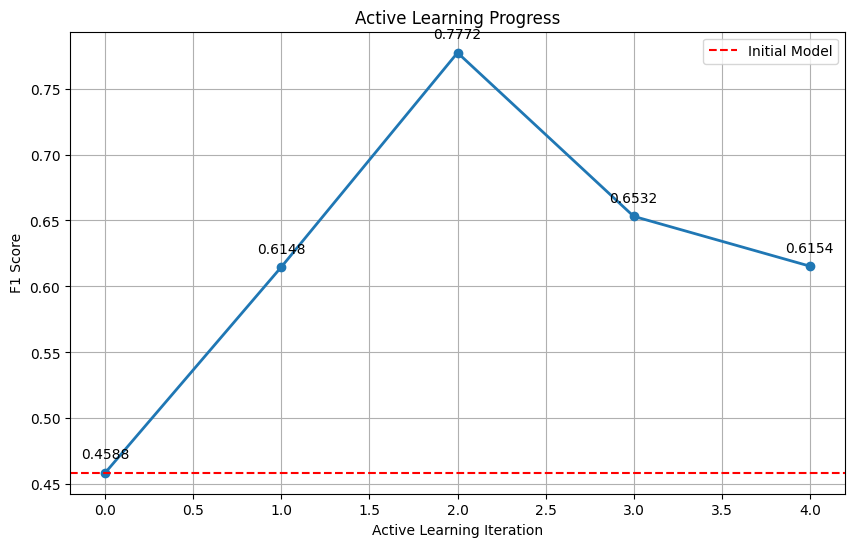


=== Active Learning Summary ===
Initial F1 Score: 0.4588
Final F1 Score: 0.6154
Absolute Improvement: 0.1566
Relative Improvement: 34.13%
Initial training dataset size: 400 samples
Final training dataset size: 560 samples
Additional labeled samples: 160 samples

F1 Score progression across iterations:
  Initial: 0.4588
  Iteration 1: 0.6148 (+0.1560)
  Iteration 2: 0.7772 (+0.1624)
  Iteration 3: 0.6532 (-0.1240)
  Iteration 4: 0.6154 (-0.0378)

The final model and all data are saved in:
/content/drive/My Drive/Team Project/PreTrained_AL/Journal


In [ ]:
# Step 15: Evaluate initial model if we don't have scores yet
if not f1_scores:
    print("\n=== Initial Model Evaluation ===")
    initial_predictions, initial_true_labels = evaluate_model(model, orig_test_loader, device)
    initial_f1 = f1_score(initial_true_labels, initial_predictions, average="macro")
    print(f"Initial F1 Score on Original Test Set: {initial_f1:.4f}")
    f1_scores = [initial_f1]

# Step 16: Active Learning Loop
num_iterations = 4  # Set number of active learning iterations
samples_per_iteration = 50  # Number of samples to select per iteration

for iteration in range(start_iteration, num_iterations):
    print(f"\n=== Active Learning Iteration {iteration+1}/{num_iterations} ===")

    # Track dataset size before adding new samples
    print(f"Labeled dataset size before iteration {iteration+1}: {len(labeled_df)} samples")
    print(f"Unlabeled dataset size before iteration {iteration+1}: {len(unlabeled_df)} samples")

    unlabeled_df = unlabeled_df[unlabeled_df['text_cleaned'].notna() & (unlabeled_df['text_cleaned'] != "")]

    # Step 16.1: Select uncertain samples
    selected_indices = select_uncertain_samples(
        model, unlabeled_df['text_cleaned'].tolist(), tokenizer, device, k=samples_per_iteration
    )

    # Step 16.2: Save selected samples for labeling
    selected_samples = unlabeled_df.iloc[selected_indices]
    selected_file = os.path.join(output_dir, f"selected_for_labeling_iter{iteration+1}.xlsx")
    selected_samples.to_excel(selected_file, index=False)

    print(f"Selected {len(selected_indices)} samples for labeling")
    print(f"Samples saved to: {selected_file}")
    print("\nIMPORTANT: Please follow these steps:")
    print("1. Open the file in Excel/Google Sheets")
    print("2. Add your annotations in the 'final_label' column")
    print("3. Save the file with the same name and location")
    print("\nLabeling Guidelines:")
    print("- Use comma-separated values for multiple labels")
    print("- Make sure to add a label for every row")
    print("- Save your work frequently")

    # Wait for user to complete labeling
    input("\nPress Enter after labeling is complete...")

    # Step 16.3: Load newly labeled data
    newly_labeled_file = os.path.join(output_dir, f"selected_for_labeling_iter{iteration+1}.xlsx")

    # Check if file exists
    if not os.path.exists(newly_labeled_file):
        print(f"Error: Could not find {newly_labeled_file}")
        print("Please make sure you have labeled the data and saved it correctly")
        break

    newly_labeled_df = pd.read_excel(newly_labeled_file)

    # Verify that labels have been added
    if newly_labeled_df['final_label'].isna().sum() > 0:
        missing_labels = newly_labeled_df['final_label'].isna().sum()
        print(f"Warning: {missing_labels} rows are missing labels")
        print("Please complete the labeling and save the file again")
        input("\nPress Enter after completing all labels...")
        newly_labeled_df = pd.read_excel(newly_labeled_file)

    # Add er_labels column to newly labeled data
    newly_labeled_df['er_labels'] = newly_labeled_df['final_label'].apply(
        lambda x: [label.strip() for label in x.split(",")] if pd.notna(x) else ["None"]
    )

    # Step 16.4: Update datasets
    # Add newly labeled samples to labeled dataset
    labeled_df = pd.concat([labeled_df, newly_labeled_df], ignore_index=True)

    # Remove selected samples from unlabeled dataset
    unlabeled_df = unlabeled_df.drop(selected_indices).reset_index(drop=True)

    # Save updated datasets
    labeled_file = os.path.join(output_dir, f"labeled_data_iter{iteration+1}.xlsx")
    unlabeled_file = os.path.join(output_dir, f"unlabeled_data_iter{iteration+1}.xlsx")

    labeled_df.to_excel(labeled_file, index=False)
    unlabeled_df.to_excel(unlabeled_file, index=False)

    print(f"Updated labeled dataset size: {len(labeled_df)} samples")
    print(f"Updated unlabeled dataset size: {len(unlabeled_df)} samples")

    # Step 16.5: Prepare updated training data
    y_labels_updated = mlb.transform(labeled_df['er_labels'])

    X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(
        labeled_df['text_ner'], y_labels_updated, test_size=0.2, random_state=42
    )

    # Update datasets and dataloaders
    train_dataset_updated = ERDataset(X_train_updated.tolist(), y_train_updated, tokenizer, max_length)
    test_dataset_updated = ERDataset(X_test_updated.tolist(), y_test_updated, tokenizer, max_length)

    train_loader_updated = DataLoader(train_dataset_updated, batch_size=batch_size, shuffle=True)
    test_loader_updated = DataLoader(test_dataset_updated, batch_size=batch_size, shuffle=False)

    # Step 16.6: Reinitialize and retrain model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=y_labels_updated.shape[1],
        problem_type="multi_label_classification",
        ignore_mismatched_sizes=True
    )
    model = model.to(device)

    # Set up loss function with class weights
    class_counts = np.sum(y_train_updated, axis=0)
    pos_weights = torch.tensor((len(y_train_updated) - class_counts) / class_counts, dtype=torch.float).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    # Set up optimizer and scheduler
    epochs = 10
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = len(train_loader_updated) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)
    scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    best_iter_f1 = 0

    print("\n=== Training Model ===")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_model(model, train_loader_updated, optimizer, loss_fn, scheduler, device)
        print(f"Train Loss: {train_loss:.4f}")

        predictions, true_labels = evaluate_model(model, test_loader_updated, device)
        f1 = f1_score(true_labels, predictions, average="macro")
        print(f"Test F1 Score: {f1:.4f}")

        # Save best model
        if f1 > best_iter_f1:
            best_iter_f1 = f1
            torch.save(model.state_dict(), os.path.join(output_dir, f"emoberta_active_learning_iter{iteration+1}.pth"))

    # Step 16.7: Evaluate on original test set for consistent tracking
    print("\n=== Evaluating on Original Test Set ===")
    model.load_state_dict(torch.load(os.path.join(output_dir, f"emoberta_active_learning_iter{iteration+1}.pth")))

    predictions, true_labels = evaluate_model(model, orig_test_loader, device)
    current_f1 = f1_score(true_labels, predictions, average="macro")
    f1_scores.append(current_f1)

    print(f"F1 Score on Original Test Set after Iteration {iteration+1}: {current_f1:.4f}")
    print(f"Improvement from Initial Model: {current_f1 - initial_f1:.4f}")

    # Step 16.8: Generate and save detailed performance report
    report = classification_report(true_labels, predictions, target_names=label_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_file = os.path.join(output_dir, f"performance_report_iter{iteration+1}.xlsx")
    report_df.to_excel(report_file)

    print(f"Detailed performance report saved to: {report_file}")

    # Step 16.9: Update progress tracking
    progress = {
        "last_completed_iteration": iteration+1,
        "f1_scores": f1_scores,
        "labeled_file": labeled_file,
        "unlabeled_file": unlabeled_file,
        "model_file": os.path.join(output_dir, f"emoberta_active_learning_iter{iteration+1}.pth"),
        "last_updated": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    with open(progress_file, "w") as f:
        json.dump(progress, f, indent=4)

# Step 17: Plot learning curve
plt.figure(figsize=(10, 6))
iterations = list(range(len(f1_scores)))
plt.plot(iterations, f1_scores, marker='o', linestyle='-', linewidth=2)
plt.axhline(y=initial_f1, color='r', linestyle='--', label='Initial Model')
plt.xlabel('Active Learning Iteration')
plt.ylabel('F1 Score')
plt.title('Active Learning Progress')
plt.grid(True)
plt.legend()

# Add numeric labels to points
for i, f1 in enumerate(f1_scores):
    plt.annotate(f"{f1:.4f}", (i, f1), textcoords="offset points", xytext=(0,10), ha='center')

# Save the plot
plt.savefig(os.path.join(output_dir, "active_learning_progress_journal.png"))
plt.show()

# Step 18: Final Summary
print("\n=== Active Learning Summary ===")
print(f"Initial F1 Score: {initial_f1:.4f}")
print(f"Final F1 Score: {f1_scores[-1]:.4f}")
print(f"Absolute Improvement: {f1_scores[-1] - initial_f1:.4f}")
print(f"Relative Improvement: {(f1_scores[-1] - initial_f1) / initial_f1 * 100:.2f}%")
print(f"Initial training dataset size: {len(X_train)} samples")
print(f"Final training dataset size: {len(X_train_updated)} samples")
print(f"Additional labeled samples: {len(X_train_updated) - len(X_train)} samples")

print("\nF1 Score progression across iterations:")
for i, f1 in enumerate(f1_scores):
    if i == 0:
        print(f"  Initial: {f1:.4f}")
    else:
        print(f"  Iteration {i}: {f1:.4f} ({f1 - f1_scores[i-1]:+.4f})")

print("\nThe final model and all data are saved in:")
print(output_dir)

# When your notebook reconnects after a disconnection:

First, make sure to run all the necessary imports and mount your Google Drive again:

```
from google.colab import drive
import torch
import pandas as pd
# (other imports as needed)
drive.mount('/content/drive')
```
The progress tracking mechanism you have in place will help you resume. Since you're saving state after each iteration in the **active_learning_progress.json** file, your code should automatically detect where it left off.

You can skip directly to the active learning loop. Define your paths to match what you had before:


```
output_dir = "/content/drive/My Drive/Team_Project/AL_File/"
progress_file = os.path.join(output_dir, "active_learning_progress.json")
```

Then run just the active learning loop portion of the code (Step 16 in your original code). The code will:
1. Read the progress file to determine the last completed iteration
2. Load the labeled and unlabeled datasets from the previous iteration
3. Load the latest trained model
4. Continue with the next iteration





